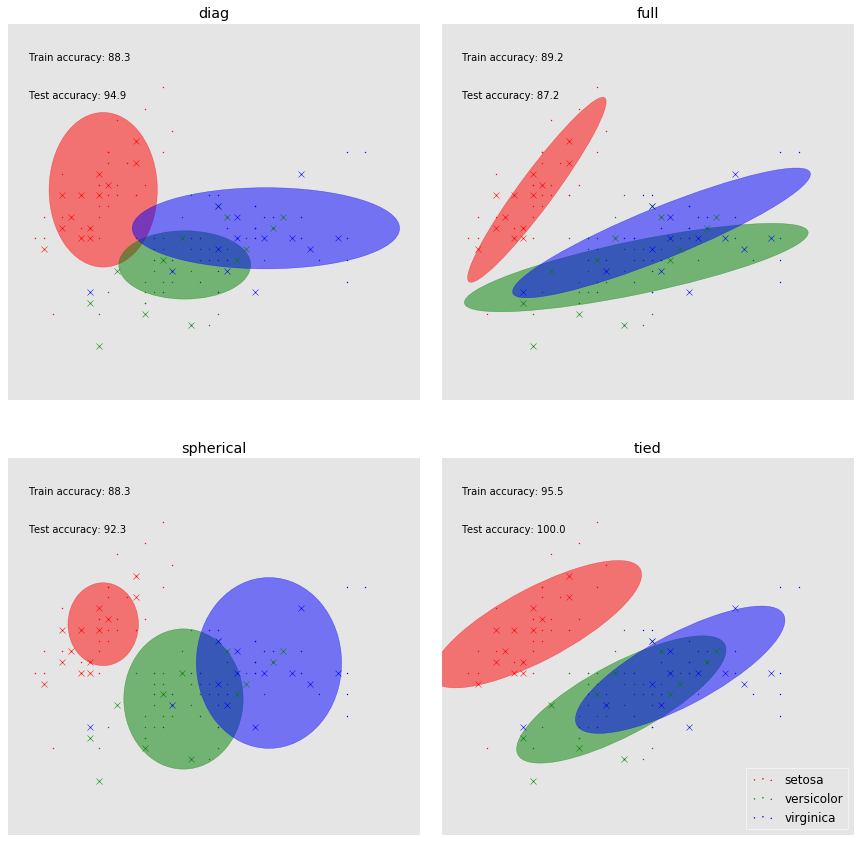

In [20]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# License: BSD 3 clause

# $Id$

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from IPython.display import display

from pylab import rcParams
rcParams['figure.figsize'] = 16,12
plt.style.use('ggplot')

%matplotlib inline

from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM


def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
classifiers = {
    covar_type: GMM(n_components    = n_classes,
                    covariance_type = covar_type, 
                    init_params     = 'wc',
                    n_iter          = 20)
    for covar_type in ['spherical', 'diag', 'tied', 'full']
}

n_classifiers = len(classifiers)

plt.figure(figsize=(6 * n_classifiers / 2, 12))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, n_classifiers / 2, index + 1)
    make_ellipses(classifier, h)

    for n, color in enumerate('rgb'):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate('rgb'):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()

In [99]:
tied = classifiers["tied"]

y_hat = pd.DataFrame(tied.predict_proba(iris.data), columns = range(n_classes))
y_hat["y"] = iris.target
y_hat["y_hat"] = tied.predict(iris.data)
y_hat["set"] = "train"
y_hat["set"].iloc[test_index] = "test"

entropieces = np.array([- y_hat[i] * np.log(y_hat[i]) for i in range(n_classes)])

y_hat["entropy"] = entropieces.sum(axis=0)
print((y_hat.set == "test").sum())

for i in range(n_classes):
    display(y_hat[y_hat.y == i].head())

39


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,0,1,2,y,y_hat,set,entropy
0,1.0,4.770630e-17,6.371715e-33,0,0,test,1.792873e-15
1,1.0,3.719229e-14,8.061437e-30,0,0,test,1.187167e-12
2,1.0,3.391934e-15,7.438789e-31,0,0,test,1.163410e-13
3,1.0,3.363333e-13,1.433411e-28,0,0,test,9.996117e-12
4,1.0,2.972389e-17,4.494449e-33,0,0,test,1.131130e-15


,0,1,2,y,y_hat,set,entropy
50,1.291742e-13,0.999692,0.000308,1,1,test,0.002800
51,5.777204e-15,0.996484,0.003516,1,1,test,0.023378
52,1.273826e-16,0.995749,0.004251,1,1,test,0.027454
53,1.909186e-16,0.999881,0.000119,1,1,test,0.001198
54,3.245831e-17,0.995651,0.004349,1,1,test,0.027991


,0,1,2,y,y_hat,set,entropy
100,6.070708e-42,2.141766e-08,1.000000,2,2,test,3.996332e-07
101,8.640557e-29,8.651977e-03,0.991348,2,2,test,4.971105e-02
102,1.505606e-32,2.231905e-04,0.999777,2,2,test,2.099636e-03
103,5.897678e-28,4.296223e-02,0.957038,2,2,test,1.772466e-01
104,1.095007e-35,1.539958e-05,0.999985,2,2,test,1.860448e-04


In [100]:
y_hat.describe()

,0,1,2,y,y_hat,entropy
count,1.500000e+02,1.500000e+02,1.500000e+02,150.000000,150.0000,1.500000e+02
mean,3.333333e-01,3.585609e-01,3.081057e-01,1.000000,0.9800,4.998854e-02
std,4.729838e-01,4.665115e-01,4.479974e-01,0.819232,0.8066,1.234291e-01
min,1.593040e-43,1.573126e-22,3.665474e-39,0.000000,0.0000,7.897689e-21
25%,4.880227e-26,2.060877e-13,8.008921e-29,0.000000,0.0000,6.223669e-12
50%,4.069398e-15,1.358965e-03,1.168304e-04,1.000000,1.0000,1.683901e-04
75%,1.000000e+00,9.958838e-01,9.316489e-01,2.000000,2.0000,2.025881e-02
max,1.000000e+00,9.999999e-01,1.000000e+00,2.000000,2.0000,6.043792e-01


In [101]:
y_hat.sort_values(by="entropy", ascending=False).head(20)

,0,1,2,y,y_hat,set,entropy
106,8.224218e-25,0.292505,0.707495,2,2,test,0.604379
77,2.063061e-20,0.719821,0.280179,1,1,train,0.593123
126,5.332896e-23,0.197260,0.802740,2,2,train,0.496580
83,2.923712e-23,0.812278,0.187722,1,1,train,0.482903
123,7.125803e-24,0.180072,0.819928,2,2,train,0.471502
138,1.120395e-22,0.160882,0.839118,2,2,train,0.441129
127,4.548109e-23,0.150547,0.849453,2,2,train,0.423656
70,4.937469e-22,0.149052,0.850948,1,2,train,0.421062
129,4.993918e-23,0.858705,0.141295,2,1,train,0.407308
116,4.406387e-26,0.074623,0.925377,2,2,train,0.265435


In [102]:
y_hat[y_hat.y != y_hat.y_hat].describe()

,0,1,2,y,y_hat,entropy
count,5.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.452533e-21,0.789246,0.210754,1.800000,1.200000,0.224997
std,2.946638e-21,0.361728,0.361728,0.447214,0.447214,0.174246
min,1.643721e-24,0.149052,0.012948,1.000000,1.000000,0.069145
25%,6.625197e-24,0.858705,0.019161,2.000000,1.000000,0.094756
50%,4.993918e-23,0.970581,0.029419,2.000000,1.000000,0.132716
75%,4.937469e-22,0.980839,0.141295,2.000000,1.000000,0.407308
max,6.710711e-21,0.987052,0.850948,2.000000,2.000000,0.421062


In [103]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=4, max_depth=3)
rf.fit(X_train, y_train)

y_hat["rf"] = rf.predict(iris.data)

print((y_hat.rf != y_hat.y).mean())

y_hat.sort_values(by="entropy", ascending=False).head(20)

0.0266666666667


,0,1,2,y,y_hat,set,entropy,rf
106,8.224218e-25,0.292505,0.707495,2,2,test,0.604379,1
77,2.063061e-20,0.719821,0.280179,1,1,train,0.593123,1
126,5.332896e-23,0.197260,0.802740,2,2,train,0.496580,2
83,2.923712e-23,0.812278,0.187722,1,1,train,0.482903,2
123,7.125803e-24,0.180072,0.819928,2,2,train,0.471502,2
138,1.120395e-22,0.160882,0.839118,2,2,train,0.441129,2
127,4.548109e-23,0.150547,0.849453,2,2,train,0.423656,2
70,4.937469e-22,0.149052,0.850948,1,2,train,0.421062,2
129,4.993918e-23,0.858705,0.141295,2,1,train,0.407308,2
116,4.406387e-26,0.074623,0.925377,2,2,train,0.265435,2


In [104]:
y_hat[y_hat.rf != y_hat.y]

,0,1,2,y,y_hat,set,entropy,rf
70,4.937469e-22,0.149052,0.850948,1,2,train,0.421062,2
83,2.923712e-23,0.812278,0.187722,1,1,train,0.482903,2
106,8.224218e-25,0.292505,0.707495,2,2,test,0.604379,1
119,6.625197e-24,0.970581,0.029419,2,1,train,0.132716,1


In [105]:
X_train.shape, y_hat.shape

((111, 4), (150, 8))